## Het U-net 

**The installations of necessary packages on the virtual machine.**

In [30]:
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 8.1 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**The necessary imports of the packages that are used during the program.**

In [1]:
import os
import glob
import monai
from PIL import Image
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import tqdm
import numpy as np

**The definition of the location of the database of ACDC and verification of the datapath location.**

In [2]:
data_path = "./preprocessed/"
if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain training and testing folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


**The selection of the correct and availble GPUs on the virtual machine.**

In [5]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

if torch.cuda.is_available():
    # CUDA
    gpu = torch.device('cuda:7')
else:
    # MacBook with >M1 chip
    gpu = torch.device('mps')

The used device is cuda:7


**Definition of the basic U-net model based on the tutorial.**

In [57]:
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(gpu)

**A modification of the build dictonary function of the tutorials to make sure the ACDC database can be allocated on the right place.**

In [8]:
# print(img.header.structarr['pixdim'])

def build_dict_ACDC(data_path, mode='train', heart_mode='Off'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'training', 'val' or 'testing'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    dicts2 = []
    paths_mri = []
    iBegin = 1
    iEnd = 101
    
    if (mode=='test'):
        iBegin = 101
        iEnd = 151
        
    for i in tqdm.tqdm(range(iBegin,iEnd)):
    # list all .png files in directory, including the path
        paths_mri.append(glob.glob(os.path.join(data_path, mode, 'patient{:03}'.format(i), '*[!gt].png')))
        # print( paths_mri)
        # make a corresponding list for all the mask files
        for mri_path in paths_mri[0]:
            # print(mri_path)
            if mode == 'test':
                suffix = 'val'
            else:
                suffix = mode
                       
            mask_path = os.path.join(mri_path[0:-4]+'_gt'+ '.png')
            # print(mask_path)
            if os.path.exists(mask_path):
                if (heart_mode=='Off'):
                    dicts.append({'img': mri_path, 'mask': mask_path})
                    # print("yes")
                    
                      
                else:
                    
                    if 'ED' in mri_path:
                        dicts.append({'img': mri_path, 'mask': mask_path})
                        
                    else:
                        dicts2.append({'img': mri_path, 'mask': mask_path})
                        
                        
                        
            paths_mri.clear()        
    if (heart_mode=='Off'):   
        return dicts
    else:
        return dicts, dicts2
        
                    

ES, ED = build_dict_ACDC(data_path, heart_mode="On")
print(len(ED))

100%|██████████| 100/100 [00:00<00:00, 285.27it/s]

951


**A modification of the LoadTranform function to make sure that only the image data is used in the DL model.**

Some things are commented out for adaptation purposes later in the project

In [79]:
class LoadMriData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        image = Image.open(sample['img']).convert('L') # import as grayscale image
        # image = nib.load(sample['img']).get_fdata()
        image = np.array(image, dtype=np.uint8)
        mask = Image.open(sample['mask']).convert('L') # import as grayscale image
        # mask = nib.load(sample['mask']).get_fdata()
        mask = np.array(mask, dtype=np.uint8)
        # slice = sample['slice']
        # mask has value 255 on rib pixels. Convert to binary array
        # mask[np.where(mask==255)] = 1
        # mask[np.where(mask>0 & mask <255)] = 0.5
        return {'img': image, 'mask': mask, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

**A function, modified from tutorials, to visualize the images together with their masks.**

In [45]:
def visualize_mri_sample(sample, title=None):
# Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    print(np.unique(mask))
    plt.figure(figsize=[10,7])
   
    # mask1 = np.empty([212,212])
    # mask2 = np.empty([212,212])
    # mask3 = np.empty([212,212])
    mask1 = np.where(mask==255,1,0)
    mask2 = np.where(mask==85,1,0)
    mask3= np.where(mask==170,1,0)
    overlay_mask1 = np.ma.masked_where(mask1 == 0, mask1 == 1)
    overlay_mask2 = np.ma.masked_where(mask2 == 0, mask2 == 1)
    overlay_mask3 = np.ma.masked_where(mask3 == 0, mask3 == 1)
    plt.imshow(image, 'gray')
    plt.imshow(overlay_mask1, 'Reds', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask2, 'Blues', alpha = 0.7, clim=[0,1], interpolation='nearest')
    plt.imshow(overlay_mask3, 'Purples', alpha = 0.7, clim=[0,1], interpolation='nearest')

    
    
    # mask1 = np.empty([212,212])
    # mask2 = np.empty([212,212])
    # mask3 = np.empty([212,212])
    if title is not None:
        plt.title(title)
    plt.show()

**Testing the function whether they perform as intended.**

Loading dataset: 100%|██████████| 1902/1902 [00:02<00:00, 722.56it/s]


[  0  85 170 255]


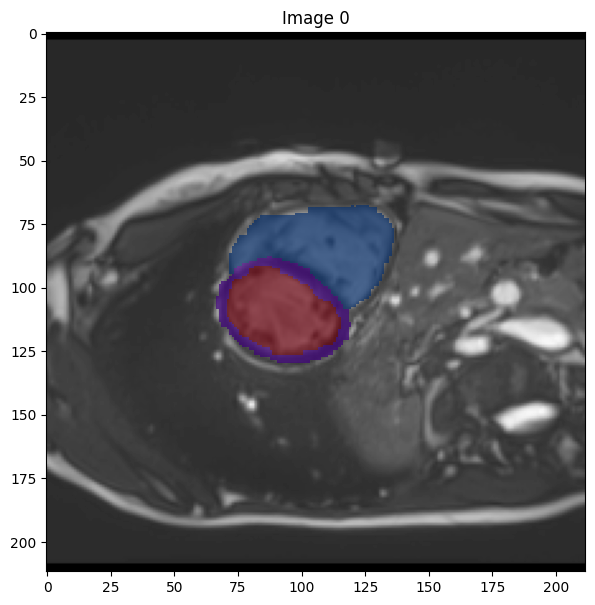

[  0  85 170 255]


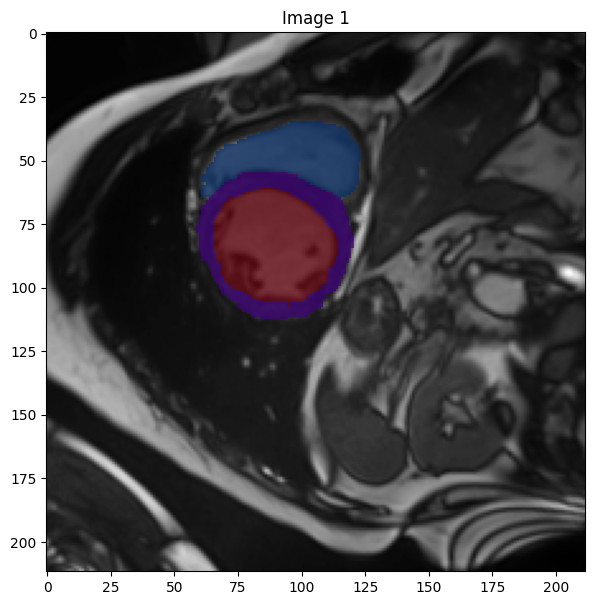

[  0  85 170 255]


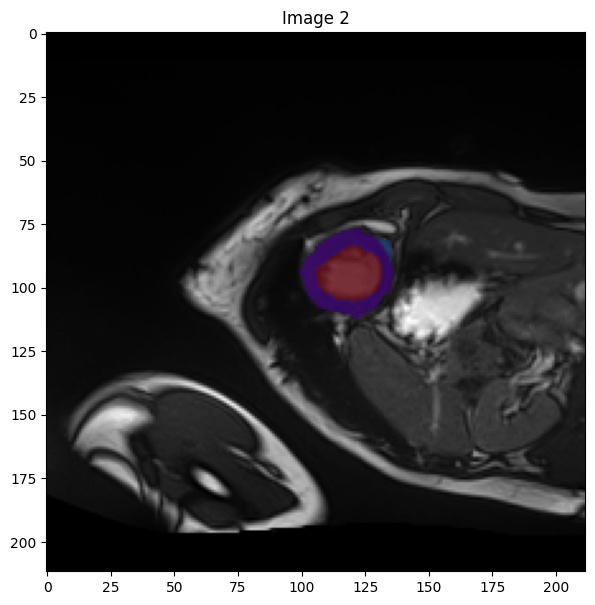

[  0  85 170 255]


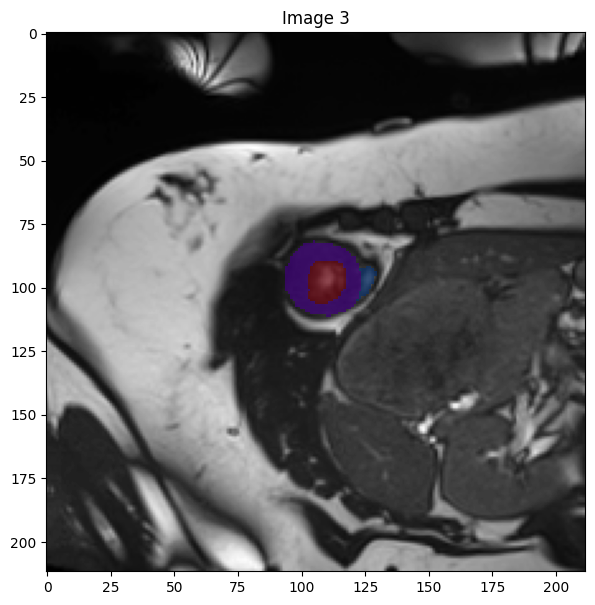

[  0  85 170 255]


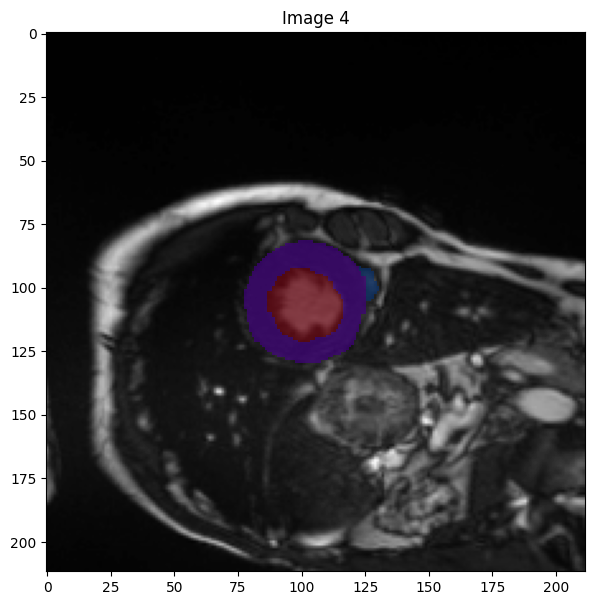

In [149]:
train_dict_list = build_dict_ACDC(data_path)
train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadMriData())

for i in range(5):
    value = np.random.randint(0, len(train_dataset))
    image = train_dataset[value]
    visualize_mri_sample(image, "Image " + str(i))

**Create a dataloader for the corresponding data.**

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)